# Smoothed-gridded seismicity of the Indian Subcontinent

This is an attempt to reproduce the results of Nath & Thingbaijam (2012) since their electronic supplement is in error.

In [1]:
%matplotlib inline
%load_ext autoreload

In [2]:
import os
from copy import deepcopy
from StringIO import StringIO
from IPython.display import display

import numpy as np
import pandas as pd
import lxml.etree as et
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import toolbox as tb
%autoreload 2
import source_model_tools as smt

from openquake.hazardlib import tom, geo
import hmtk.sources as src
import hmtk.plotting.seismicity.catalogue_plots as scp

from hmtk.parsers.catalogue import CsvCatalogueParser
from hmtk.plotting.mapping import HMTKBaseMap
from hmtk.seismicity.smoothing.smoothed_seismicity import SmoothedSeismicity
%autoreload 2
from hmtk.seismicity.smoothing.kernels.isotropic_gaussian import IsotropicGaussian

In [8]:
layer_ids = [1, 2, 3, 4]
layer_depths_km = [0, 25, 70, 180, 300]

df_layers = pd.DataFrame(zip(layer_ids, layer_depths_km[:-1], layer_depths_km[1:]), columns=['id','zmin','zmax'])
df_layers

,id,zmin,zmax
0,1,0,25
1,2,25,70
2,3,70,180
3,4,180,300


In [9]:
# define some lists needed at different stages
min_mags = [4.5, 5.5]
corr_dists_km = [65, 85]

mag_bin = 0.2
time_bin = 1.0

catalogue_txt = '../Catalogue/SACAT1900_2008v2.txt'
catalogue_csv = catalogue_txt.replace('.txt','.csv')
completeness_csv = '../Data/thingbaijam2011seismogenic/Table1.csv'

model_path = '../Data/nath2012probabilistic'
old_txt_template = os.path.join(model_path,'lay%dsmooth%.1f.txt')
recomputed_path = './Recomputed'
large_csv_template = os.path.join(recomputed_path, 'smoothed_seismicity_layer%d_mmin%g.csv')
small_csv_template = os.path.join(recomputed_path, 'smoothed_source_model_mmin_%g_layer_%d.csv')
new_txt_template = os.path.join(recomputed_path, os.path.split(old_txt_template)[1])

In [30]:
# read completeness table
completeness_df = pd.read_csv(completeness_csv, header=[0,1], index_col=[0,1])
completeness_df.columns = [' '.join(col).strip() for col in completeness_df.columns.values]
completeness_df.reset_index(inplace=True)
completeness_df

,zmin,zmax,4 start,4 end,4.5 start,4.5 end,5.5 start,5.5 end
0,0,25,1994,2008,1964,2008,1903,2008
1,25,70,1990,2008,1964,2008,1902,2008
2,70,180,1996,2008,1964,2008,1914,2008
3,180,300,1970,2008,1984,2008,1912,2008


In [31]:
pd.merge(completeness_df, df_layers)

,zmin,zmax,4 start,4 end,4.5 start,4.5 end,5.5 start,5.5 end,id
0,0,25,1994,2008,1964,2008,1903,2008,1
1,25,70,1990,2008,1964,2008,1902,2008,2
2,70,180,1996,2008,1964,2008,1914,2008,3
3,180,300,1970,2008,1984,2008,1912,2008,4


In [5]:
# reformat the catalogue and write it to CSV
catalogue_reformat_df = pd.read_csv(catalogue_txt, sep='\t')
catalogue_reformat_df.columns = [item.lower() for item in catalogue_reformat_df.columns]
catalogue_reformat_df['eventID'] = catalogue_reformat_df.index.values
RENAME_COLS = {
    'source': 'Agency',
    'lat': 'latitude',
    'lon': 'longitude',
    'hh': 'hour',
    'mm': 'minute',
    'ss': 'second',
    'mag_mw': 'magnitude',
    'mag_mw_err': 'sigmaMagnitude',
    'depth_err': 'depthError',
    'shock_type': 'comment',
}
catalogue_reformat_df.rename(columns=RENAME_COLS, inplace=True)
catalogue_reformat_df.to_csv(catalogue_csv, index=False)

In [6]:
# parse the CSV catalogue
parser = CsvCatalogueParser(catalogue_csv) 
catalogue = parser.read_file() 

print 'Number of entries:', len(catalogue.data['eventID'])
print 'Keys before cleaning:', ', '.join(catalogue.data.keys())

min_lon, max_lon, min_lat, max_lat = catalogue.get_bounding_box()
print 'Longitudes: %g to %g' % (min_lon, max_lon)
print 'Latitudes: %g to %g' % (min_lat, max_lat)

catalogue.sort_catalogue_chronologically()

Catalogue Attribute mag_err is not a recognised catalogue key
Catalogue Attribute nmag_type is not a recognised catalogue key
Catalogue Attribute mag is not a recognised catalogue key
Number of entries: 50331
Keys before cleaning: eventID, comment, sigmaMagnitude, hour, SemiMinor90, magnitude, Agency, second, longitude, month, depthError, flag, depth, magnitudeType, SemiMajor90, timeError, year, latitude, ErrorStrike, day, minute
Longitudes: 55 to 101
Latitudes: 2 to 40


In [7]:
#purge events which are too small to be of interest
mag_negligible = 1.
too_small = catalogue.data['magnitude'] <= mag_negligible
catalogue.purge_catalogue(~too_small)
print 'Purged %d events below M=%g' % (sum(too_small), mag_negligible)

Purged 52 events below M=1


In [9]:
# assign layer ids
layer_id_array = np.full_like(catalogue.data['depth'], np.nan)
for layer in df_layers.iterrows():
    at_depth = ((catalogue.data['depth'] >= layer['zmin']) & 
                (catalogue.data['depth'] < layer['zmax']))
    layer_id_array[at_depth] = layer['layerid']
catalogue.data['layerid'] = layer_id_array

too_deep = catalogue.data['depth'] > layer_depths_km[-1]
unassigned = catalogue.data['depth'] < layer_depths_km[0]
catalogue.purge_catalogue(~too_deep & ~unassigned)
print 'Purged %d events below %g km depth' % (sum(too_deep), layer_depths_km[-1])
print 'Purged %d events with unassigned depths' % sum(unassigned)

Purged 46 events below 300 km depth
Purged 878 events with unassigned depths


In [10]:
# clean out empty keys and then make a dataframe (for ease of display and query)
for key in catalogue.data.keys():
    if len(catalogue.data[key]) == 0:
        catalogue.data.pop(key)
catalogue_data_df = pd.DataFrame(catalogue.data)
catalogue_data_df = catalogue_data_df[['eventID','Agency','comment','layerid','magnitude','sigmaMagnitude','year','month','day','hour','minute','second','longitude','latitude','depth','depthError']]

In [12]:
print 'Minimum magnitudes:'
display(catalogue_data_df.sort(columns='magnitude').head(5))
print 'Maximum magnitudess:'
display(catalogue_data_df.sort(columns='magnitude').tail(20))

Minimum magnitudes:


,eventID,Agency,comment,layerid,magnitude,sigmaMagnitude,year,month,day,hour,minute,second,longitude,latitude,depth,depthError
42066,43031,ISC,Mainshock,4,2,0.39,2006,6,7,21,24,33.96,71.5915,37.6533,267.4,1
42102,43067,ISC,Mainshock,4,2,0.39,2006,6,13,6,53,9.98,72.9257,39.0171,226.4,49
36673,37638,ISC,Mainshock,1,2,0.40,2005,4,1,21,59,46.97,71.4398,39.2769,12.6,64
39549,40514,ISC,Mainshock,2,2,0.40,2005,10,19,19,30,32.02,69.3876,38.8408,26.9,3
21735,22693,ISC,Mainshock,1,2,0.39,2000,3,1,16,19,43.80,77.1650,31.3650,10.0,-1


Maximum magnitudess:


,eventID,Agency,comment,layerid,magnitude,sigmaMagnitude,year,month,day,hour,minute,second,longitude,latitude,depth,depthError
38903,39868,GCMT,Mainshock,1,7.6,0.10,2005,10,8,3,50,38.84,73.617,34.485,15.7,0.0
21,75,AB2003a,Mainshock,2,7.6,-1.00,1911,2,18,18,41,-1.00,72.800,38.000,26.0,-1.0
358,561,ISC,Mainshock,2,7.6,0.23,1947,3,17,8,19,32.00,99.500,33.000,35.0,-1.0
127,266,T2008a;MD1984a,Mainshock,2,7.6,0.40,1931,1,27,20,9,-1.00,96.800,25.600,60.0,-1.0
17,63,ISC,Mainshock,4,7.7,0.23,1909,7,7,21,37,50.00,70.500,36.500,230.0,-1.0
360,564,T2008a,Mainshock,2,7.7,0.40,1947,7,29,13,43,22.00,94.000,28.500,60.0,-1.0
324,511,B2005a,Mainshock,2,7.7,0.10,1941,6,26,11,52,-1.00,92.500,12.100,55.0,-1.0
1,6,UL2006a,Mainshock,2,7.7,-1.00,1902,8,22,3,-1,-1.00,76.200,39.880,30.0,-1.0
225,383,AB2003a,Mainshock,1,7.7,0.30,1935,5,30,21,33,46.00,66.500,29.600,20.0,-1.0
23160,24120,M2004a,Mainshock,1,7.7,0.10,2001,1,26,3,16,41.86,70.289,23.410,16.0,0.0


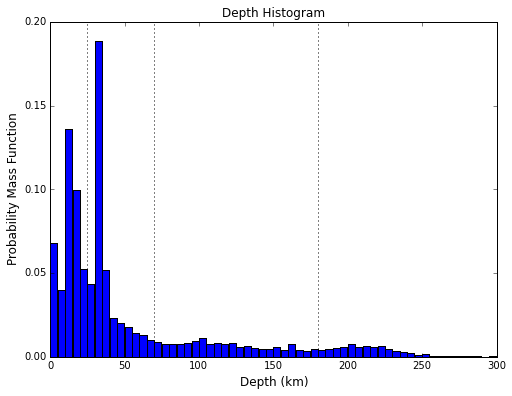

In [13]:
scp.plot_depth_histogram(catalogue, 5, normalisation=True)
[plt.axvline(x, color='black', linestyle=':') for x in layer_depths_km];

In [14]:
completeness_tables = [[[[completeness_df.loc[z_min, z_max][str(mag), 'start'], mag]]
                        for mag in min_mags] 
                       for z_min, z_max in zip(layer_depths_km[:-1], layer_depths_km[1:])]
completeness_tables

[[[[1964, 4.5]], [[1903, 5.5]]],
 [[[1964, 4.5]], [[1902, 5.5]]],
 [[[1964, 4.5]], [[1914, 5.5]]],
 [[[1984, 4.5]], [[1912, 5.5]]]]

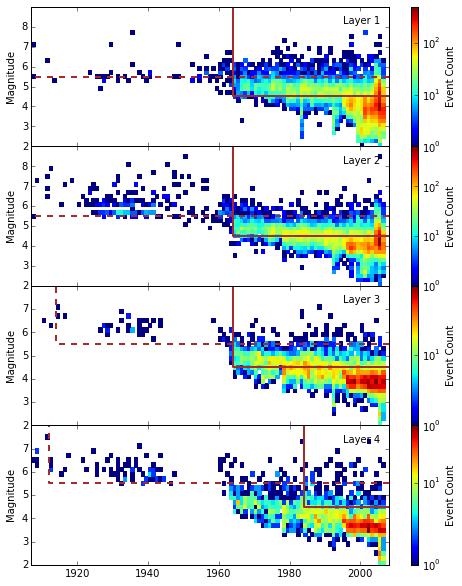

In [15]:
fig, axes = plt.subplots(len(layer_ids), 1, figsize=(8,10), sharex=True)
fig.subplots_adjust(hspace=0)
for ax, layer_id, completeness_tables_layer in zip(axes, layer_ids, completeness_tables):
    plt.sca(ax)
    tb.annotate('Layer %d' % layer_id)

    catalogue_layer = deepcopy(catalogue)
    in_layer = catalogue_layer.data['layerid'] == layer_id
    catalogue_layer.select_catalogue_events(in_layer)
    scp.plot_magnitude_time_density(
        catalogue_layer, mag_bin, time_bin, 
        completeness=completeness_tables_layer)

In [16]:
declustered = deepcopy(catalogue)

# Logical indexing: Chossing the outputs for the main events: Cluster_flag = 0 
is_mainshock = [item == 'Mainshock' for item in declustered.data['comment']]

# Filtering the foreshocks and aftershocks in the copy of the catalogue 
declustered.purge_catalogue(is_mainshock)

# Printing the number of events considered main shocks
print 'Retained', declustered.get_number_events(), 'out of', catalogue.get_number_events(), 'events'

Retained 30056 out of 49355 events


In [26]:
# compute smoothed-gridded seismicity - INTENSIVE!
grid_step = 0.2
grid_setup = [min_lon - grid_step/2., max_lon + grid_step/2., grid_step, 
              min_lat - grid_step/2., max_lat + grid_step/2., grid_step, 0., 1000., 1000.]  
smoother = SmoothedSeismicity(grid_setup, use_3d=False, bvalue=1.0)

for layer_id, layer_completeness_tables \
        in zip(layer_ids, completeness_tables):
    for min_mag, corr_dist_km, completeness_table \
            in zip(min_mags, corr_dists_km, layer_completeness_tables):
        kernel_config = {'Length_Limit': 3., 'BandWidth': corr_dist_km, 'increment': False}

        catalogue_layer = deepcopy(declustered)
        in_layer = catalogue_layer.data['layerid'] == layer_id
        catalogue_layer.select_catalogue_events(in_layer)
        above_min = catalogue_layer.data['magnitude'] >= min_mag
        print "Layer %d: %d events, %d with M >= %g" % (
            layer_id, catalogue_layer.get_number_events(), sum(above_min), min_mag)

        large_csv = large_csv_template % (layer_id, min_mag)
        output_data = smoother.run_analysis(catalogue_layer, kernel_config, np.array(completeness_table), 
                                            smoothing_kernel=IsotropicGaussian())
        smoother.write_to_csv(smoothed_csv)

Layer 1: 11093 events, 4030 with M >= 4.5
Smoothing Total Rate Comparison - Observed: 4030, Smoothed: 4042.94
Layer 1: 11093 events, 539 with M >= 5.5
Smoothing Total Rate Comparison - Observed: 539, Smoothed: 540.941
Layer 2: 10804 events, 4699 with M >= 4.5
Smoothing Total Rate Comparison - Observed: 4699, Smoothed: 4707.31
Layer 2: 10804 events, 521 with M >= 5.5
Smoothing Total Rate Comparison - Observed: 521, Smoothed: 519.693
Layer 3: 5763 events, 2048 with M >= 4.5
Smoothing Total Rate Comparison - Observed: 2048, Smoothed: 2049.26
Layer 3: 5763 events, 177 with M >= 5.5
Smoothing Total Rate Comparison - Observed: 177, Smoothed: 177.458
Layer 4: 2391 events, 612 with M >= 4.5
Smoothing Total Rate Comparison - Observed: 612, Smoothed: 612.241
Layer 4: 2391 events, 128 with M >= 5.5
Smoothing Total Rate Comparison - Observed: 128, Smoothed: 128.177


In [20]:
# do some filtering and reprocessing of smoothed seismicity
for min_mag in min_mags:
    for layer_id in layer_ids:
        
        large_csv = large_csv_template % (layer_id, min_mag)
        small_csv = small_csv_template % (min_mag, layer_id)
        old_txt = old_txt_template % (layer_id, min_mag)
        new_txt = new_txt_template % (layer_id, min_mag)
        
        df_new = pd.read_csv(large_csv)
        df_old = pd.read_csv(old_txt)
        df_old.rename(columns={'latitude': 'Latitude', 
                               'lat': 'Latitude', 
                               'longitude': 'Longitude', 
                               'lon': 'Longitude'}, inplace=True)
        df_new = pd.merge(df_old, df_new)
        df_new['Smoothed Rate'] = df_new['Smoothed Rate'].round(6)
        df_new.drop(['Depth', 'b-value'], axis=1, inplace=True)
        df_new.to_csv(small_csv, index=False)
        
        rename_cols = {'Smoothed Rate': 'nu', 'Latitude':'lat', 'Longitude': 'lon'}
        df_new.rename(columns=rename_cols, inplace=True)
        df_new = df_new[['lon', 'lat', 'nu']]
        df_new.to_csv(new_txt, index=False, sep=',', float_format='%g')

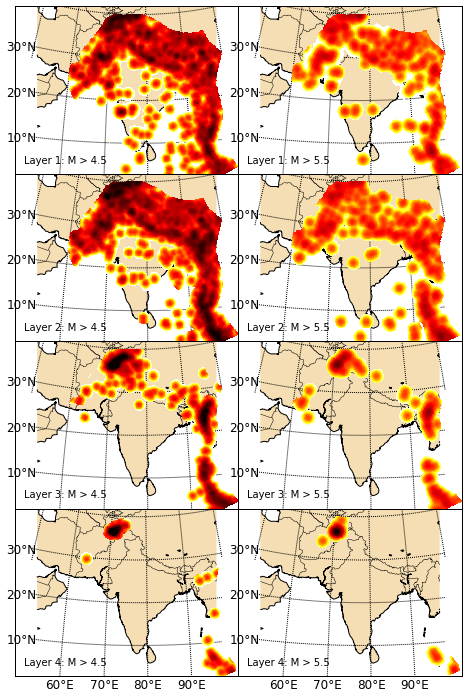

In [25]:
map_config = {'min_lon': min_lon, 'max_lon': max_lon, 'min_lat': min_lat, 'max_lat': max_lat, 
              'parallel_meridian_spacing': 10, 'resolution':'l'}

fig, axes = plt.subplots(len(layer_ids), len(min_mags), figsize=(8,12), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0, wspace=0)
plt.set_cmap('hot_r')
for layer_axes, layer_id in zip(axes, layer_ids):
    for ax, min_mag in zip(layer_axes, min_mags):
        plt.sca(ax)
        tb.annotate('Layer %d: M > %g' % (layer_id, min_mag), 'lower left')

        small_csv = small_csv_template % (min_mag, layer_id)
        df = pd.read_csv(small_csv)
        basemap = HMTKBaseMap(map_config, None)
        basemap.add_colour_scaled_points(
            df['Longitude'].values, df['Latitude'].values, 
            df['Smoothed Rate'].values, size=1, alpha=1,
            norm=LogNorm(1e-4, 2), overlay=True, add_colorbar=False)
fig.savefig('SmoothingPrelimFixed.png', dpi=300, bbox_inches='tight')

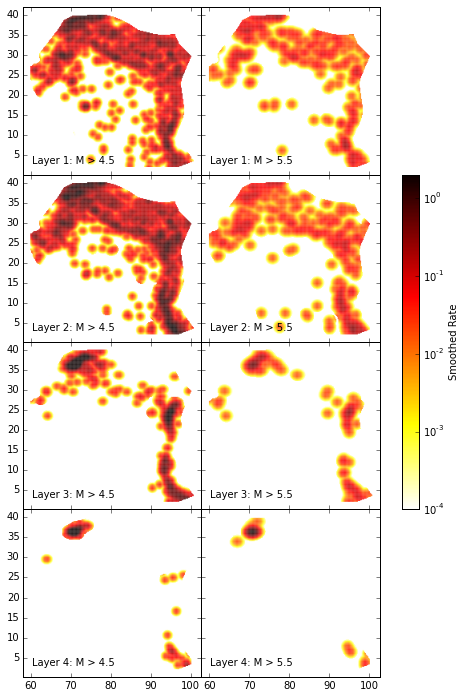

In [33]:
fig, axes = plt.subplots(len(layer_ids), len(min_mags), 
                         figsize=(8,12), sharex=True, sharey=True,
                         subplot_kw={'adjustable': 'datalim', 'aspect': 1})
fig.subplots_adjust(hspace=0, wspace=0)
for layer_axes, layer_id in zip(axes, layer_ids):
    for ax, min_mag in zip(layer_axes, min_mags):
        plt.sca(ax)
        tb.annotate('Layer %d: M > %g' % (layer_id, min_mag), 'lower left')

        small_csv = small_csv_template % (min_mag, layer_id)

        df = pd.read_csv(small_csv)
        im = plt.scatter(df['Longitude'].values, df['Latitude'].values, 
                    c=df['Smoothed Rate'].values, s=1, edgecolor='none', 
                    cmap='hot_r', norm=LogNorm(1e-4, 2))
plt.gca().set_aspect('equal')
plt.autoscale(enable=True, axis=u'both', tight=True)
fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.5, label='Smoothed Rate')

fig.savefig('SmoothedRecalculatedNoMap.pdf', dpi=300, bbox_inches='tight')

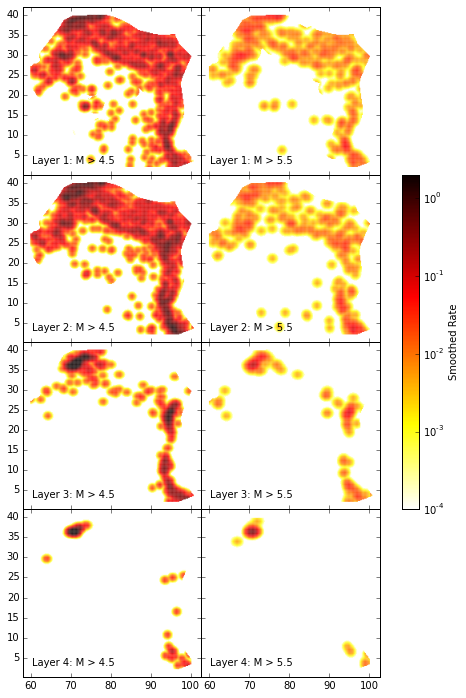

In [32]:
fig, axes = plt.subplots(len(layer_ids), len(min_mags), 
                         figsize=(8,12), sharex=True, sharey=True,
                         subplot_kw={'adjustable': 'datalim', 'aspect': 1})
fig.subplots_adjust(hspace=0, wspace=0)
for layer_axes, layer_id in zip(axes, layer_ids):
    for ax, min_mag in zip(layer_axes, min_mags):
        plt.sca(ax)
        tb.annotate('Layer %d: M > %g' % (layer_id, min_mag), 'lower left')

        small_csv = small_csv_template % (min_mag, layer_id)
         
        df = pd.read_csv(small_csv)
        nu_mag = [item for item in df.keys() if 'nu' in item][0]
        im = plt.scatter(df['Longitude'].values, df['Latitude'].values, 
                    c=df[nu_mag].values, s=1, edgecolor='none',
                    cmap='hot_r', norm=LogNorm(1e-4, 2))
plt.gca().set_aspect('equal')
plt.autoscale(enable=True, axis=u'both', tight=True)
fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.5, label='Smoothed Rate')

fig.savefig('SmoothedThinbaigjamNoMap.pdf', dpi=300, bbox_inches='tight')

In [20]:
c = 85  # km correlation distance
delta = 0.1  # grid spacing
span = 2.5  # test grid span
lon = 80  # degrees
lat = 20  # degrees
point = geo.Point(lon, lat)
lon_list = np.arange(lon - span, lon + span + delta/2, delta)
lat_list = np.arange(lat - span, lat + span + delta/2, delta)
lon_limits = (lon - span - delta/2, lon + span + delta/2)
lat_limits = (lat - span - delta/2, lat + span + delta/2)
lon_mesh, lat_mesh = np.meshgrid(lon_list, lat_list)
mesh = geo.RectangularMesh(lon_mesh, lat_mesh)
distances = point.distance_to_mesh(mesh)
i_mid = int(span/delta)
span_km = (distances[i_mid,:].max(), distances[:,i_mid].max())
print('Grid extents %g and %g km' % span_km)
print('Must be at least 3x correlation distance or %g km' % (3*c))
if all(np.array(span_km) > 3*c):
    print 'OK!'
else:
    print 'Problem!'
weights = np.exp(-(distances/c)**2) * (distances < 3*c)
print(u'For correlation distance %g km and grid spacing %g°' % (c, delta))
print('the unnormalized weights sum to %g.' % weights.sum())

Grid extents 261.22 and 277.987 km
Must be at least 3x correlation distance or 255 km
OK!
For correlation distance 85 km and grid spacing 0.1°
the unnormalized weights sum to 195.338.


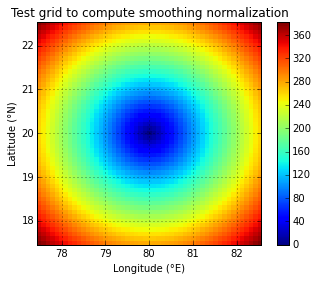

In [21]:
plt.imshow(distances, origin='lower', aspect='equal', 
           interpolation='nearest', 
           extent=lon_limits + lat_limits)
plt.title('Test grid to compute smoothing normalization')
plt.xlabel(u'Longitude (°E)')
plt.ylabel(u'Latitude (°N)')
plt.grid()
plt.colorbar();

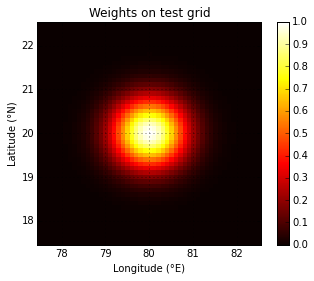

In [22]:
plt.imshow(weights, cmap='hot', origin='lower', aspect='equal', 
           interpolation='nearest', 
           extent=lon_limits + lat_limits)
plt.title('Weights on test grid')
plt.xlabel(u'Longitude (°E)')
plt.ylabel(u'Latitude (°N)')
plt.grid()
plt.colorbar();